# packages

In [57]:
options(stringsAsFactors = F)
library(ggplot2)
library(dplyr)
library(ggrepel)
library(monocle)
library(Seurat)
library(cowplot)
library(RColorBrewer)
library(pheatmap)
library(scater)
library(princurve)
source("https://raw.githubusercontent.com/leezx/Toolsets/master/R/Toolsets.R")
source("https://raw.githubusercontent.com/leezx/Toolsets/master/R/Plot.R")

# human main data

In [28]:
# print(load("keyRdata/sce.all.Rdata"))
# # contains all ctrl cells, no HSCR
# sce_dev <- sce[, sce$cellType %in% c("ctrl_iPSC","ctrl_ENCC","ctrl_N_D20","ctrl_N_D40")]

In [8]:
# print(load("keyRdata/sce_dev.Rdata"))

In [69]:
table(sce_dev$cellGroup)


          IMR_iPSC            UE_iPSC           IMR_ENCC            UE_ENCC 
               192                192                398                390 
    IMR_N_Diff_D20      UE_N_Diff_D20     IMR_N_Diff_D40      UE_N_Diff_D40 
               384                400                384                384 
  IMR_SAG_ENCC_0_4  IMR_SAG_ENCC_0_10 IMR_SAG_N_Diff_D20           HSCR_5c3 
                 0                  0                  0                  0 
          HSCR_6c5          HSCR_10c2          HSCR_20c7          HSCR_23c9 
                 0                  0                  0                  0 
         HSCR_1c11 
                 0 

Warning message:
“call 'runPCA' explicitly to compute results”


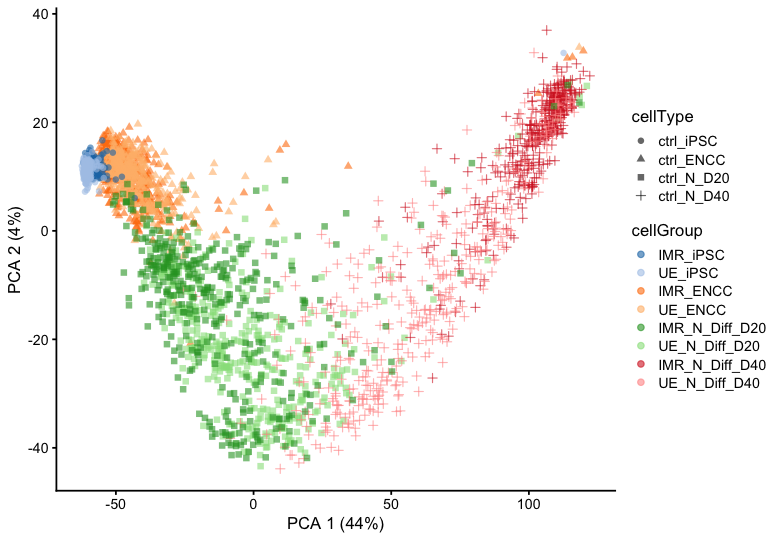

In [9]:
set.seed(49)
options(repr.plot.width=6.5, repr.plot.height=4.5)
pca_full <- scater::plotPCA(sce_dev, colour_by="cellGroup", shape_by="cellType")
pca_full

In [10]:
pca_full_data <- pca_full$data
pca_full_data$group <- pca_full_data$colour_by
pca_full_data$group <- plyr::mapvalues(x = pca_full_data$group, 
                                       from = c("IMR_iPSC", "UE_iPSC", "IMR_ENCC", "UE_ENCC", 
                                                "IMR_N_Diff_D20","IMR_N_Diff_D40",
                                                "UE_N_Diff_D20", "UE_N_Diff_D40"), 
                                       to = c("hPSC", "hPSC", "hNC", "hNC", 
                                              "hNP-D20", "hNP-D40", "hNP-D20", "hNP-D40"))

In [12]:
# unsupervised clustering for D20 and D40
print(load("keyRdata/sce_neuron_lineage.Rdata"))

[1] "sce_comp" "pca_data"


In [13]:
pca_full_data$cluster <- as.character(pca_full_data$colour_by)
pca_full_data[rownames(pca_data),]$cluster <- as.character(pca_data$colour_by)

In [14]:
myColors_human_4set <- c("#984EA3", "#E41A1C", "#377EB8", "#4DAF4A")

In [15]:
centers <- pca_full_data %>% dplyr::group_by(group) %>% summarize(X = median(x = X), 
            Y = median(x = Y))

In [17]:
pricu1 <- princurve::principal_curve(as.matrix(pca_full_data[,c("X","Y")]), 
                          smoother='lowess', trace=F, stretch=1000) # f=1/3,
# two DMCs
pc.line1 <- as.data.frame(pricu1$s[order(pricu1$lambda), ])

In [23]:
pca_full_data$pseudotime <- pricu1$lambda/max(pricu1$lambda)
# orient maturation score using Nes expression
if (cor(pca_full_data$pseudotime, logcounts(sce_dev)['TOP2A', rownames(pca_full_data)]) > 0) {
pca_full_data$pseudotime <- -(pca_full_data$pseudotime - max(pca_full_data$pseudotime))
}

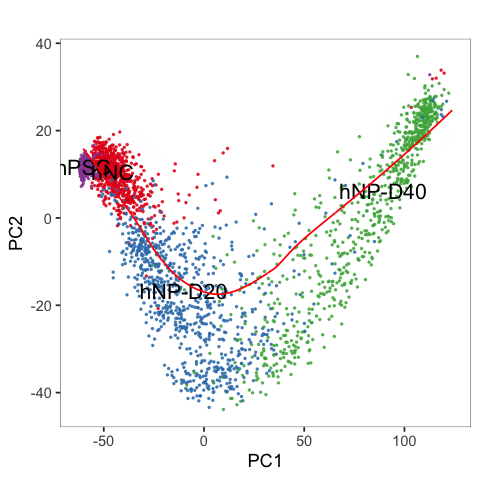

In [24]:
options(repr.plot.width=4, repr.plot.height=4)
pcag <- ggplot(pca_full_data, aes(x=X, y=Y, color=group)) +
    # facet_grid(cols = vars(variable)) +
    # facet_wrap( ~ variable, ncol=2) + # error in border
    geom_point(size=0.3, alpha=0.8) +
    geom_density_2d(color='black', size=0.05, alpha=0.15) +
    geom_text(data = centers, mapping = aes(label = group), size = 4.5, color="black") +
    geom_line(data=pc.line1, color='red', size=0.5) +
    labs(x = "PC1",y = "PC2", title = "") +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
    theme(legend.title=element_blank()) +
    theme(legend.position = "none") +
    theme(strip.background = element_rect(fill = "gray97", color = NA)) + # strip background color
    theme(strip.placement = "outside", strip.text.x = element_text(face="plain", size = 14), #italic
          strip.text.y = element_text(face="plain", size = 11)) +
    theme(panel.spacing=unit(.3, "lines"),panel.border = element_rect(color = "black", fill = NA, size = 0.2,colour = "black")) + #line size
    scale_color_manual(values=myColors_human_4set)
pcag

Warning message:
“stat_contour(): Zero contours were generated”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message:
“stat_contour(): Zero contours were generated”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message:
“stat_contour(): Zero contours were generated”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


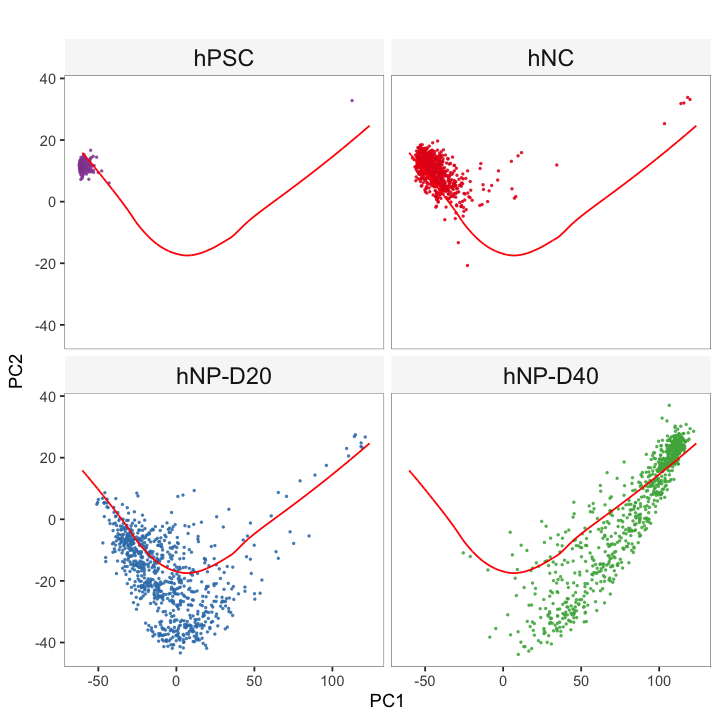

In [25]:
options(repr.plot.width=6, repr.plot.height=6)
pcag <- ggplot(pca_full_data, aes(x=X, y=Y, color=group)) +
    # facet_grid(cols = vars(variable)) +
    facet_wrap( ~ group, ncol=2) + # error in border
    geom_point(size=0.3, alpha=0.8) +
    geom_density_2d(color='black', size=0.05, alpha=0.15) +
    #geom_text(data = centers, mapping = aes(label = group), size = 4.5, color="black") +
    geom_line(data=pc.line1, color='red', size=0.5) +
    labs(x = "PC1",y = "PC2", title = "") +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
    theme(legend.title=element_blank()) +
    theme(legend.position = "none") +
    theme(strip.background = element_rect(fill = "gray97", color = NA)) + # strip background color
    theme(strip.placement = "outside", strip.text.x = element_text(face="plain", size = 14), #italic
          strip.text.y = element_text(face="plain", size = 11)) +
    theme(panel.spacing=unit(.3, "lines"),panel.border = element_rect(color = "black", fill = NA, size = 0.2,colour = "black")) + #line size
    scale_color_manual(values=myColors_human_4set)
pcag

Warning message:
“stat_contour(): Zero contours were generated”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message:
“stat_contour(): Zero contours were generated”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message:
“stat_contour(): Zero contours were generated”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message:
“stat_contour(): Zero contours were generated”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message:
“stat_contour(): Zero contours were generated”
Warning message in min(x):
“no non-missing arguments to min; returni

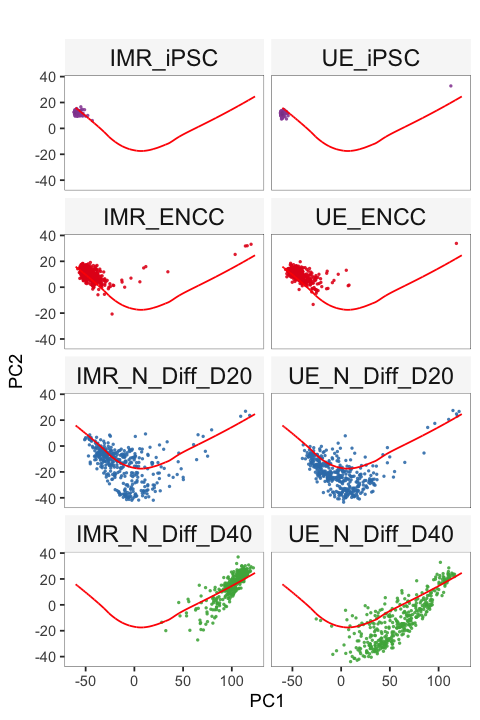

In [26]:
options(repr.plot.width=4, repr.plot.height=6)
pcag <- ggplot(pca_full_data, aes(x=X, y=Y, color=group)) +
    # facet_grid(cols = vars(variable)) +
    facet_wrap( ~ colour_by, ncol=2) + # error in border
    geom_point(size=0.3, alpha=0.8) +
    geom_density_2d(color='black', size=0.05, alpha=0.15) +
    #geom_text(data = centers, mapping = aes(label = group), size = 4.5, color="black") +
    geom_line(data=pc.line1, color='red', size=0.5) +
    labs(x = "PC1",y = "PC2", title = "") +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
    theme(legend.title=element_blank()) +
    theme(legend.position = "none") +
    theme(strip.background = element_rect(fill = "gray97", color = NA)) + # strip background color
    theme(strip.placement = "outside", strip.text.x = element_text(face="plain", size = 14), #italic
          strip.text.y = element_text(face="plain", size = 11)) +
    theme(panel.spacing=unit(.3, "lines"),panel.border = element_rect(color = "black", fill = NA, size = 0.2,colour = "black")) + #line size
    scale_color_manual(values=myColors_human_4set)
pcag

In [27]:
# full ctrl, IMR and UE
save(pca_full_data, sce_dev, file="keyRdata/sce_dev.Rdata")

# mouse main data

In [29]:
print(load("keyRdata/all_ENCC_merged3.Rdata"))

[1] "seuset"   "all_tsne" "markers" 


In [33]:
myColors <- brewer.pal(8,"Set2")

In [68]:
table(all_tsne$group)


ctrl kif7  vcl  pos  neg 
3849 4585 4218  182 1048 

In [30]:
head(all_tsne)

,tSNE_1,tSNE_2,ident,x,y,pt.size,PC1,PC2,cluster,group,ref,raw_cluster,glia,cluster2
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<fct>,<lgl>,<chr>
vcl_GGATTACAGAACAATC,41.299913,7.189895,c7,41.299913,7.189895,1,-6.235536,0.2513959,c1,vcl,new,c7,FALSE,c3
vcl_AACTGGTCAACTGCGC,26.982326,-3.567126,c2,26.982326,-3.567126,1,-7.303446,-0.6065070,c5,vcl,new,c2,FALSE,c2
vcl_GCGGGTTTCTGTACGA,2.684877,5.906441,c4,2.684877,5.906441,1,-6.050432,0.5311239,c6,vcl,new,c4,FALSE,c1
vcl_AAGGCAGGTTCCAACA,1.716174,-10.047217,c1,1.716174,-10.047217,1,-3.246502,3.4400086,c2,vcl,new,c1,FALSE,c4
vcl_ACCAGTACAGACAAAT,8.358311,20.315951,c4,8.358311,20.315951,1,-8.023777,-1.1029122,c6,vcl,new,c4,FALSE,c1
vcl_TCTATTGGTTATCCGA,22.492369,16.328948,c2,22.492369,16.328948,1,-6.288876,3.0361640,c5,vcl,new,c2,FALSE,c2


In [31]:
centers <- all_tsne %>% dplyr::group_by(cluster) %>% summarize(PC1 = median(x = PC1), 
            PC2 = median(x = PC2))

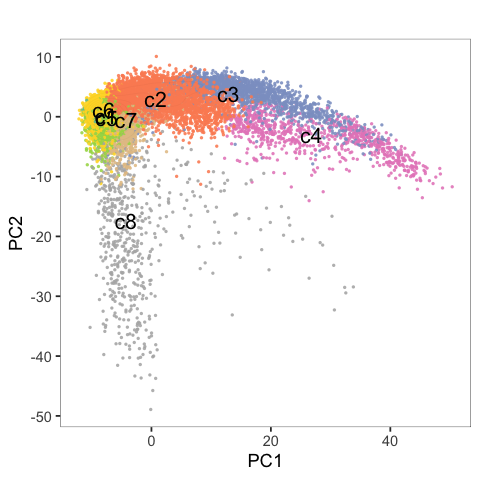

In [35]:
options(repr.plot.width=4, repr.plot.height=4)
pcag_l <- ggplot(all_tsne, aes(x=PC1, y=PC2, color=cluster)) +
    # facet_grid(cols = vars(variable)) +
    # facet_wrap( ~ variable, ncol=2) + # error in border
    geom_point(size=0.3, alpha=0.8) +
    geom_density_2d(color='black', size=0.05, alpha=0.15) +
    geom_text(data = centers, mapping = aes(label = cluster), size = 4.5, color="black") +
    # geom_line(data=pc.line1, color='red', size=0.5) +
    labs(x = "PC1",y = "PC2", title = "") +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
    theme(legend.title=element_blank()) +
    theme(legend.position = "none") +
    theme(strip.background = element_rect(fill = "gray97", color = NA)) + # strip background color
    theme(strip.placement = "outside", strip.text.x = element_text(face="plain", size = 14), #italic
          strip.text.y = element_text(face="plain", size = 11)) +
    theme(panel.spacing=unit(.3, "lines"),panel.border = element_rect(color = "black", fill = NA, size = 0.2,colour = "black")) + #line size
    scale_color_manual(values=myColors)
pcag_l

# comparision

In [36]:
# load sce contrain all cell lines
print(load("keyRdata/sce_comp_sub.Rdata"))

[1] "sce_comp_sub"      "pca_full_data_dev"


In [67]:
table(sce_comp_sub$cellGroup)


          IMR_iPSC            UE_iPSC           IMR_ENCC            UE_ENCC 
               192                192                398                390 
    IMR_N_Diff_D20      UE_N_Diff_D20     IMR_N_Diff_D40      UE_N_Diff_D40 
               384                400                384                384 
  IMR_SAG_ENCC_0_4  IMR_SAG_ENCC_0_10 IMR_SAG_N_Diff_D20           HSCR_5c3 
                 0                  0                  0                  0 
          HSCR_6c5          HSCR_10c2          HSCR_20c7          HSCR_23c9 
                 0                  0                  0                  0 

In [37]:
sce_comp <- sce_comp_sub
pca_data <- pca_full_data_dev
sce_comp$cellGroup2<- as.character(pca_data[sce_comp$cellName,]$merge)

In [38]:
# common genes
# common TFs
# make no big differences
common_TFs <- data.frame(mouse=rownames(seuset@raw.data), human=toupper(rownames(seuset@raw.data)))

In [39]:
# get common TFs
common_TFs <- common_TFs[common_TFs$mouse %in% rownames(seuset@scale.data),]
common_TFs <- common_TFs[common_TFs$human %in% rownames(sce_comp),]
dim(common_TFs)

[1] 12944     2

In [40]:
mouse_exprM <- as.matrix(t(seuset@raw.data[,rownames(all_tsne)]))
dim(mouse_exprM)

[1] 13882 15953

In [41]:
mouse_exprM <- mouse_exprM[,colSums(mouse_exprM)>0]
common_TFs <- common_TFs[common_TFs$mouse %in% colnames(mouse_exprM),]
dim(common_TFs)

[1] 12944     2

In [42]:
median_c <- 10000
mouse_exprM_scale <- mouse_exprM/rowSums(mouse_exprM)*median_c
mouse_exprM_scale <- log2(1+mouse_exprM_scale)
mouse_exprM_scale <- as.data.frame(as.matrix(t(mouse_exprM_scale)))
mouse_exprM_scale[1:5,1:5]

,vcl_GGATTACAGAACAATC,vcl_AACTGGTCAACTGCGC,vcl_GCGGGTTTCTGTACGA,vcl_AAGGCAGGTTCCAACA,vcl_ACCAGTACAGACAAAT
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Xkr4,0.000000,0.000000,0.000000,0.000000,0.0000000
Mrpl15,1.601993,1.241046,0.718156,0.000000,0.0000000
Lypla1,2.019145,0.000000,0.718156,0.000000,0.0000000
Gm37988,0.000000,0.000000,0.000000,0.000000,0.0000000
Tcea1,0.000000,0.000000,0.000000,1.473931,0.8381141


In [43]:
mouse_exprM_scale <- mouse_exprM_scale[common_TFs$mouse,]
dim(mouse_exprM_scale)

[1] 12944 13882

In [44]:
human_exprM_scale <- logcounts(sce_comp)[common_TFs$human,]
dim(human_exprM_scale)

[1] 12944  2724

In [45]:
mouse_c_exprM <- data.frame()

for (i in unique(all_tsne$cluster)) {
    #print(i)
    mouse_c_exprM <- rbind(mouse_c_exprM, 
                           as.vector(apply(mouse_exprM_scale[, rownames(all_tsne)[all_tsne$cluster == i]], 1, mean)))
}

colnames(mouse_c_exprM) <- rownames(mouse_exprM_scale)
rownames(mouse_c_exprM) <- unique(all_tsne$cluster)
dim(mouse_c_exprM)

[1]     8 12944

In [46]:
human_c_exprM <- data.frame()

for (i in unique(sce_comp$cellGroup2)) {
    #print(i)
    human_c_exprM <- rbind(human_c_exprM, 
                           as.vector(apply(human_exprM_scale[, sce_comp$cellGroup2==i], 1, mean)))
}

colnames(human_c_exprM) <- rownames(human_exprM_scale)
rownames(human_c_exprM) <- unique(sce_comp$cellGroup2)
dim(human_c_exprM)

[1]    12 12944

In [47]:
# 影响不大
gene_c <- rowSums(human_exprM_scale>0)
human_g <- names(gene_c)[gene_c>10]

gene_c <- rowSums(t(mouse_c_exprM)>0)
mouse_g <- names(gene_c)[gene_c>0]

In [48]:
common_TFs <- common_TFs[common_TFs$human %in% human_g & common_TFs$mouse %in% mouse_g,]

In [49]:
# corM <- cor(t(human_c_exprM[,common_TFs$human]), t(mouse_c_exprM)[common_TFs$mouse,], method = "spearman")

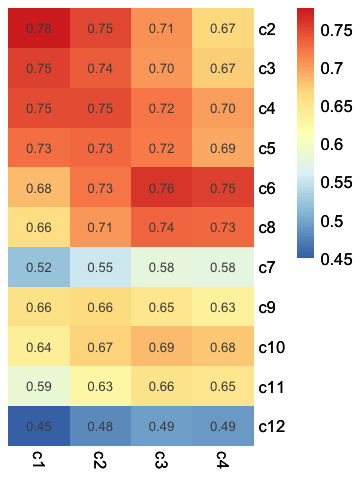

In [50]:
options(repr.plot.width=3, repr.plot.height=4)
corM2 <- corM[c(paste("c",2:6, sep=""), "c8","c7", paste("c",9:12, sep="")), 
              c(paste("c",1:4, sep=""))] # , paste("c",9:12, sep="")
# corM2 <- corM[c_order, c("c1","c2","c3","c4","c'1","c'2","c'3","c'4")]
hp2 <- pheatmap(corM2, cluster_rows = F, cluster_cols = F, border_color = NA, display_numbers = T)
hp2

# SAG treatment

In [51]:
# sce_SAG <- sce[, sce$cellType %in% c("ctrl_iPSC","ctrl_ENCC","ctrl_N_D20","ctrl_N_D40","SAG_ENCC", "SAG_N_D20")]

In [53]:
print(load("SAG/SAG.Rdata"))

[1] "sce_SAG"           "pca_full_data"     "pca_full_data_sub"


Warning message:
“call 'runPCA' explicitly to compute results”


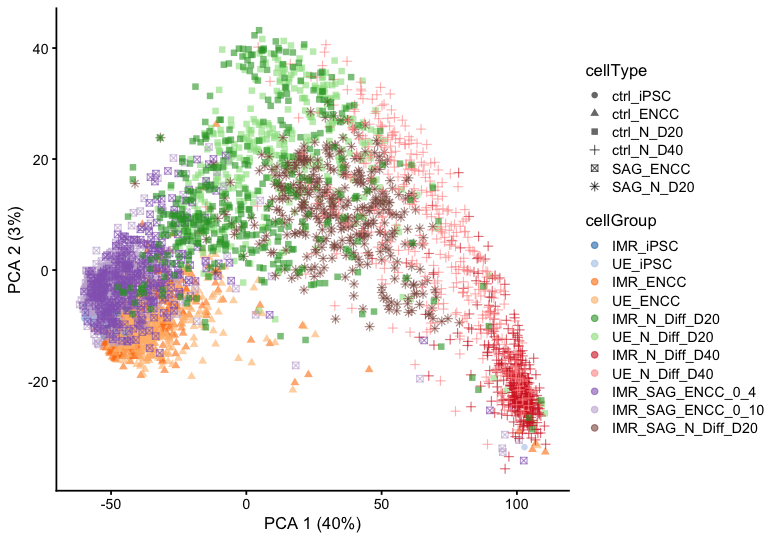

In [54]:
set.seed(49)
options(repr.plot.width=6.5, repr.plot.height=4.5)
pca_full <- scater::plotPCA(sce_SAG, colour_by="cellGroup", shape_by="cellType")
pca_full

In [55]:
centers <- pca_full_data %>% dplyr::group_by(group) %>% summarize(X = median(x = X), 
            Y = median(x = Y))

In [58]:
pricu1 <- principal_curve(as.matrix(pca_full_data[,c("X","Y")]), 
                          smoother='lowess', trace=F, stretch=1000) # f=1/3,
# two DMCs
pc.line1 <- as.data.frame(pricu1$s[order(pricu1$lambda), ])

In [59]:
pca_full_data$pseudotime <- pricu1$lambda/max(pricu1$lambda)
# orient maturation score using Nes expression
if (cor(pca_full_data$pseudotime, logcounts(sce_SAG)['TOP2A', rownames(pca_full_data)]) > 0) {
pca_full_data$pseudotime <- -(pca_full_data$pseudotime - max(pca_full_data$pseudotime))
}

In [60]:
myColors_human_5set <- c("#984EA3", # hPSC
                         "#E41A1C", # hNC
                         "#FF7F00", # hNC-SAG0_4
                         "#F781BF", # hNC-SAG0_10
                         "#377EB8", # hNP-D20
                         "#A65628",  # hNP-SAG-D20
                         "#4DAF4A" # hNP-D40
                        )

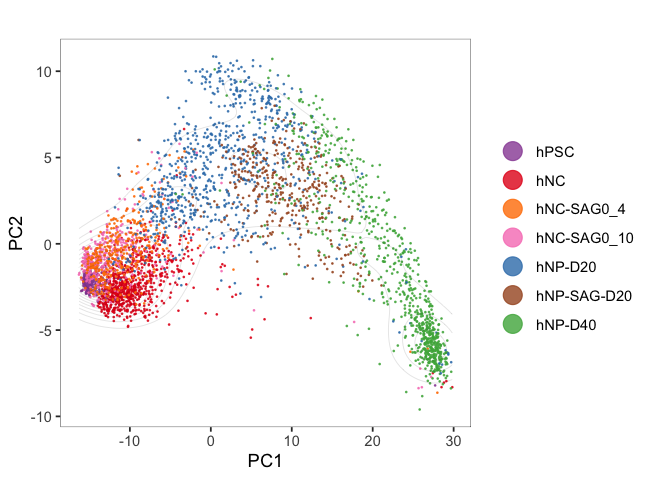

In [61]:
options(repr.plot.width=5.5, repr.plot.height=4)
pcag <- ggplot(pca_full_data, aes(x=X, y=Y, color=group)) +
    # facet_grid(cols = vars(variable)) +
    # facet_wrap( ~ variable, ncol=2) + # error in border
    geom_point(size=0.1, alpha=0.8) +
    geom_density_2d(color='black', size=0.2, alpha=0.15) +
    #geom_text(data = centers, mapping = aes(label = group), size = 3, color="black") +
    #geom_line(data=pc.line1, color='red', size=0.5) +
    labs(x = "PC1",y = "PC2", title = "") +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
    theme(legend.title=element_blank()) +
    #theme(legend.position = "none") +
    theme(strip.background = element_rect(fill = "gray97", color = NA)) + # strip background color
    theme(strip.placement = "outside", strip.text.x = element_text(face="plain", size = 14), #italic
          strip.text.y = element_text(face="plain", size = 11)) +
    theme(panel.spacing=unit(.3, "lines"),panel.border = element_rect(color = "black", fill = NA, size = 0.2,colour = "black")) + #line size
    scale_color_manual(values=myColors_human_5set) +
    guides(colour = guide_legend(override.aes = list(size=5)))
pcag

In [62]:
library(ggpubr)

Loading required package: magrittr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [63]:
myColors_human_5set3 <- myColors_human_5set[c(2,5,6,7)]

Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`tbl_df()` was deprecated in dplyr 1.0.0.
Please use `tibble::as_tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


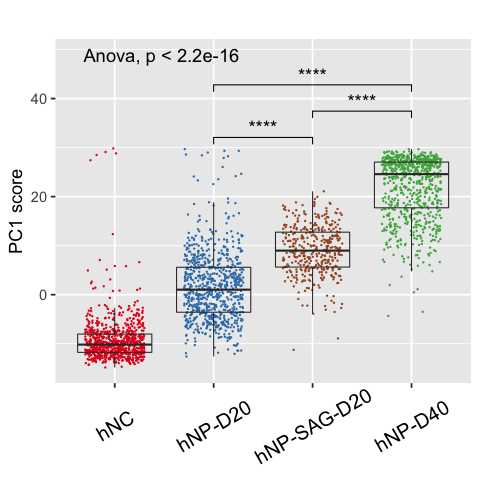

In [64]:
library(ggpubr)
my_comparisons <- list( c("hNP-D20", "hNP-SAG-D20"), c("hNP-SAG-D20", "hNP-D40"), c("hNP-D20", "hNP-D40") )
options(repr.plot.width=4, repr.plot.height=4.2)
tmp_df <- subset(pca_full_data, group %in% c("hNC", "hNP-D20", "hNP-SAG-D20", "hNP-D40"))
sig_pseudog1 <- ggplot(tmp_df, aes(x=group, y=X, fill=NA)) +
  geom_jitter(width = 0.3, size=0.001, aes(color=group)) +
  geom_boxplot(outlier.size=NA, size=0.3, outlier.shape = NA) +
  stat_compare_means(comparisons = my_comparisons, method = "t.test",label= "p.signif")+ # Add pairwise comparisons p-value
  stat_compare_means(label.y = 49, label.x = 1, method = "anova") +    # Add global p-value
  scale_fill_manual(values=myColors_human_5set3) +
  scale_color_manual(values=myColors_human_5set3) +
  theme(legend.position = "none", 
        axis.text.x  = element_text(face="plain", angle=30, size = 12, color = "black", vjust=0.6)) +
  labs(x = "", y = "PC1 score", title = "")
sig_pseudog1

In [65]:
myColors_human_5set4 <- myColors_human_5set[c(2,3,4)]

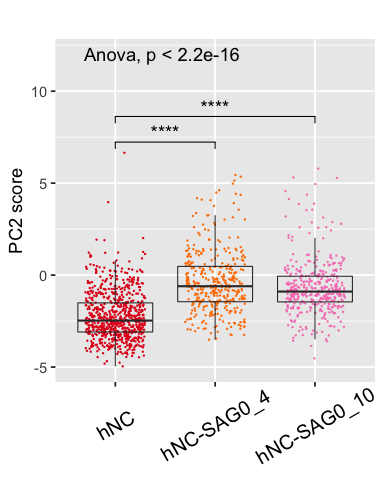

In [66]:
options(repr.plot.width=3.2, repr.plot.height=4.2)
library(ggpubr)
my_comparisons <- list( c("hNC", "hNC-SAG0_4"), c("hNC", "hNC-SAG0_10")) # , c("hNC-SAG0_4", "hNC-SAG0_10")
tmp_df <- subset(pca_full_data, group %in% c("hNC", "hNC-SAG0_4", "hNC-SAG0_10") & Y> -5)
sig_pseudog2 <- ggplot(tmp_df, aes(x=group, y=Y, fill=NA)) +
  geom_jitter(width = 0.3, size=0.001, aes(color=group)) +
  geom_boxplot(outlier.size=NA, size=0.3, outlier.shape = NA) +
  stat_compare_means(comparisons = my_comparisons, method = "wilcox.test",label= "p.signif")+ 
  # Add pairwise comparisons p-value, wilcox.test , t.test
  stat_compare_means(label.y = 12, label.x = 1, method = "anova") +    # Add global p-value
  scale_fill_manual(values=myColors_human_5set4) +
  scale_color_manual(values=myColors_human_5set4) +
  theme(legend.position = "none", 
        axis.text.x  = element_text(face="plain", angle=30, size = 12, color = "black", vjust=0.6)) +
  labs(x = "", y = "PC2 score", title = "")
sig_pseudog2